In order to detect disturbance, we can detect the model first, detect the actual sensor reading, the difference should be the disturbance.

In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

Detect disturbance using forcing function

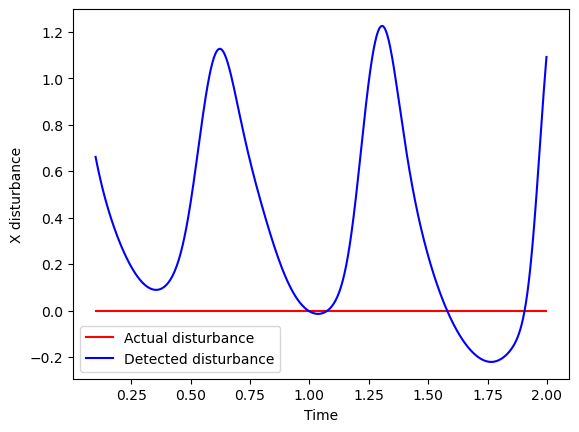

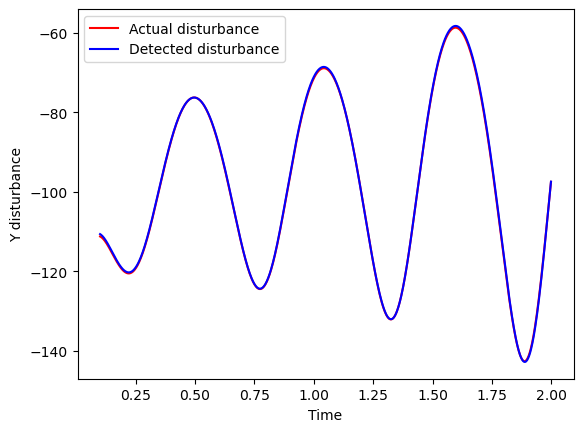

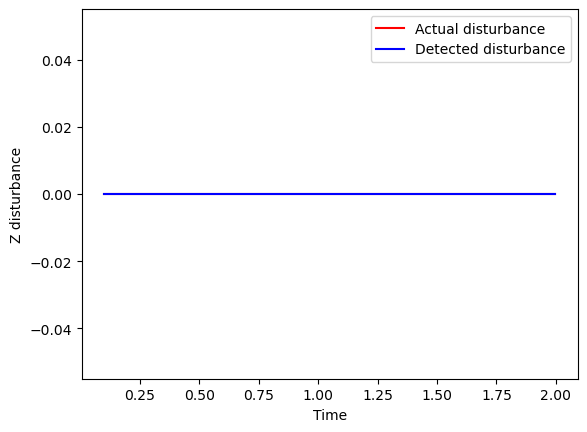

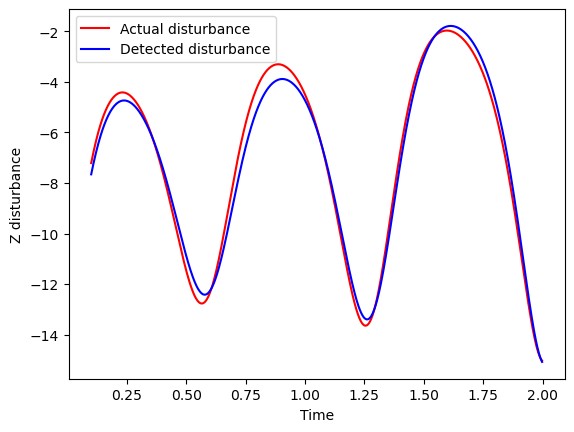

In [25]:
## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1500                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10

## Simulation parameters
T = 200
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 100 * np.cos(0.05 * dt * t)
    fy = 100 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 10

gxnocontrol = np.zeros(ntest)
gxcontrol = np.zeros(ntest)
gpredx = np.zeros(ntest)
ux = np.zeros(ntest + 1)
vx = np.zeros(ntest + 1)

gynocontrol = np.zeros(ntest)
gycontrol = np.zeros(ntest)
gpredy = np.zeros(ntest)
uy = np.zeros(ntest + 1)
vy = np.zeros(ntest + 1)

gznocontrol = np.zeros(ntest)
gzcontrol = np.zeros(ntest)
gpredz = np.zeros(ntest)
uz = np.zeros(ntest + 1)
vz = np.zeros(ntest + 1)

## Storing x, y, z time series data when there is disturbance and control is applied
xcontrol = np.zeros(ntest)             
ycontrol = np.zeros(ntest)
zcontrol = np.zeros(ntest)

## Storing x, y, z time series data when there is disturbance and control is not applied
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## Storing x, y, z time series data if there was no disturbance
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)


xxcontrol, yycontrol, zzcontrol = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpure, yypure, zzpure = x, y, z


temp = Wout.dot(R[:, -1])

for t in range(ntest):

    ## No disturbance and system is evolving with old parameters

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure    
    
    

    ## Disturbance but no control
    
    gynocontrol[t] = disfac * xxnocontrol

    # xrossdot = - yross - zross
    # yrossdot = xross + 0.2 * yross
    # zrossdot = 0.2 + zross * (xross - 5.7)

    # xross = xross + dt * xrossdot
    # yross = yross + dt * yrossdot
    # zross = zross + dt * zrossdot

    # gxnocontrol[t] = 50 * xross 
    # gynocontrol[t] = 50 * yross


    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol



    ## Disturbance with delayed control

    gycontrol[t] = disfac * xxnocontrol
    
    # gxcontrol[t] = 50 * xross 
    # gycontrol[t] = 50 * yross


    ux[t] = temp[0]
    uy[t] = temp[1]
    uz[t] = temp[2]

    vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
    vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
    vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

    xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
    yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
    zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

    xxcontrol += dt * xxcontrolp
    yycontrol += dt * yycontrolp
    zzcontrol += dt * zzcontrolp

    xcontrol[t] = xxcontrol
    ycontrol[t] = yycontrol
    zcontrol[t] = zzcontrol

    temp = np.array([xxcontrol, yycontrol, zzcontrol])
    r = np.tanh(A.dot(r) + Win.dot(temp) + 1)
    temp = Wout.dot(r)
    gpredx[t] = temp[0] + alpha * vx[t]
    gpredy[t] = temp[1] + alpha * vy[t]
    gpredz[t] = temp[2] + alpha * vz[t]




# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

plottimerange = np.arange(50, 1000)

# plt.figure()
# plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], xnocontrol[plottimerange],  'b', label = 'Disturbed model')
# plt.plot(testingtimes[plottimerange], xcontrol[plottimerange],  'g', label = 'Controlled model')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('X')
# plt.show()


# plt.figure()
# plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], ynocontrol[plottimerange],  'b', label = 'Disturbed model')
# plt.plot(testingtimes[plottimerange], ycontrol[plottimerange],  'g', label = 'Controlled model')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Y')
# plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gxcontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredx[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gycontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredy[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gzcontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredz[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z disturbance')
plt.show()


plottimerange = np.arange(50, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], xcontrol[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z disturbance')
plt.show()




Wait, to detect disturbance with delayed control, instead you could let it just run with disturbance, and then just find the disturbance term without trying to control. Would also be easier to find the disturbance then.

In [ ]:
## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1500                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10

## Simulation parameters
T = 200
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 100 * np.cos(0.05 * dt * t)
    fy = 100 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 10

gxnocontrol = np.zeros(ntest)
gxcontrol = np.zeros(ntest)
gpredx = np.zeros(ntest)
ux = np.zeros(ntest + 1)
vx = np.zeros(ntest + 1)

gynocontrol = np.zeros(ntest)
gycontrol = np.zeros(ntest)
gpredy = np.zeros(ntest)
uy = np.zeros(ntest + 1)
vy = np.zeros(ntest + 1)

gznocontrol = np.zeros(ntest)
gzcontrol = np.zeros(ntest)
gpredz = np.zeros(ntest)
uz = np.zeros(ntest + 1)
vz = np.zeros(ntest + 1)

## Storing x, y, z time series data when there is disturbance and control is applied
xcontrol = np.zeros(ntest)             
ycontrol = np.zeros(ntest)
zcontrol = np.zeros(ntest)

## Storing x, y, z time series data when there is disturbance and control is not applied
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## Storing x, y, z time series data if there was no disturbance
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)


xxcontrol, yycontrol, zzcontrol = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpure, yypure, zzpure = x, y, z


temp = Wout.dot(R[:, -1])

for t in range(ntest):

    ## No disturbance and system is evolving with old parameters

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure    
    
    

    ## Disturbance but no control
    
    gynocontrol[t] = disfac * xxnocontrol

    # xrossdot = - yross - zross
    # yrossdot = xross + 0.2 * yross
    # zrossdot = 0.2 + zross * (xross - 5.7)

    # xross = xross + dt * xrossdot
    # yross = yross + dt * yrossdot
    # zross = zross + dt * zrossdot

    # gxnocontrol[t] = 50 * xross 
    # gynocontrol[t] = 50 * yross


    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol



    ## Disturbance with delayed control

    gycontrol[t] = disfac * xxnocontrol
    
    # gxcontrol[t] = 50 * xross 
    # gycontrol[t] = 50 * yross


    ux[t] = temp[0]
    uy[t] = temp[1]
    uz[t] = temp[2]

    vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
    vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
    vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

    xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
    yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
    zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

    xxcontrol += dt * xxcontrolp
    yycontrol += dt * yycontrolp
    zzcontrol += dt * zzcontrolp

    xcontrol[t] = xxcontrol
    ycontrol[t] = yycontrol
    zcontrol[t] = zzcontrol

    temp = np.array([xxcontrol, yycontrol, zzcontrol])
    r = np.tanh(A.dot(r) + Win.dot(temp) + 1)
    temp = Wout.dot(r)
    gpredx[t] = temp[0] + alpha * vx[t]
    gpredy[t] = temp[1] + alpha * vy[t]
    gpredz[t] = temp[2] + alpha * vz[t]




# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

plottimerange = np.arange(50, 1000)

# plt.figure()
# plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], xnocontrol[plottimerange],  'b', label = 'Disturbed model')
# plt.plot(testingtimes[plottimerange], xcontrol[plottimerange],  'g', label = 'Controlled model')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('X')
# plt.show()


# plt.figure()
# plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], ynocontrol[plottimerange],  'b', label = 'Disturbed model')
# plt.plot(testingtimes[plottimerange], ycontrol[plottimerange],  'g', label = 'Controlled model')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Y')
# plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gxcontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredx[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gycontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredy[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gzcontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredz[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z disturbance')
plt.show()






Also, can recreate the entire system exactly by using the two reservoirs simultaneously.

From the system directly: The disturbance is added to the derivative term. so we need to find the difference between x and the previous x, and divide it by dt to get the disturbance term.

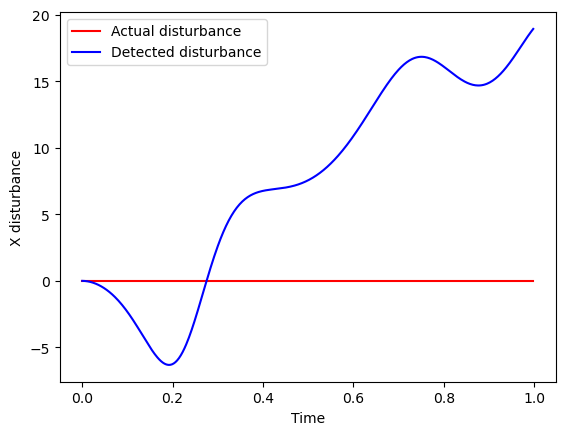

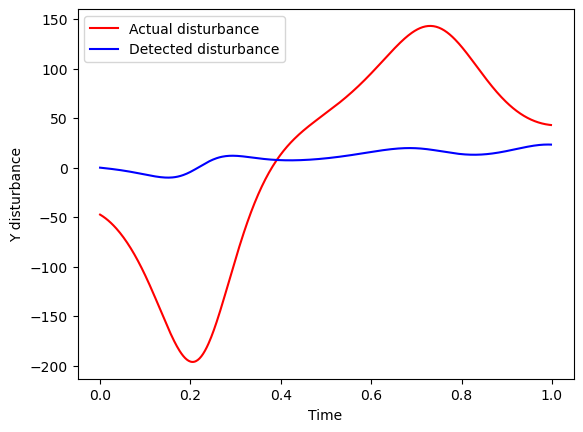

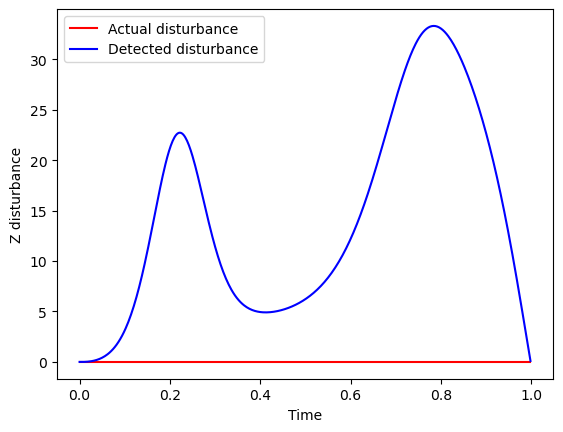

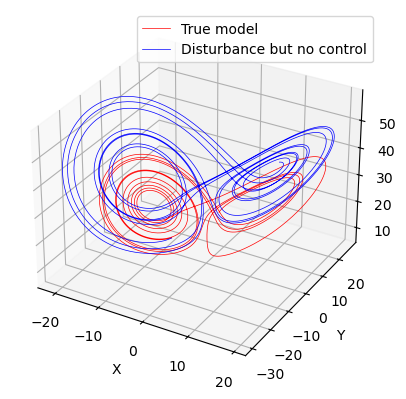

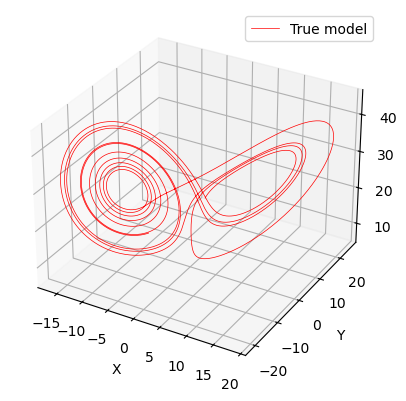

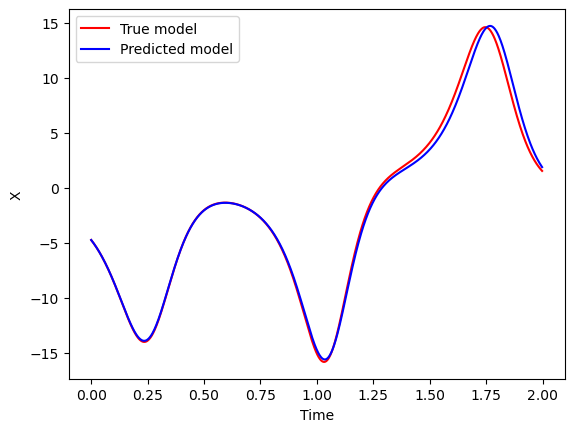

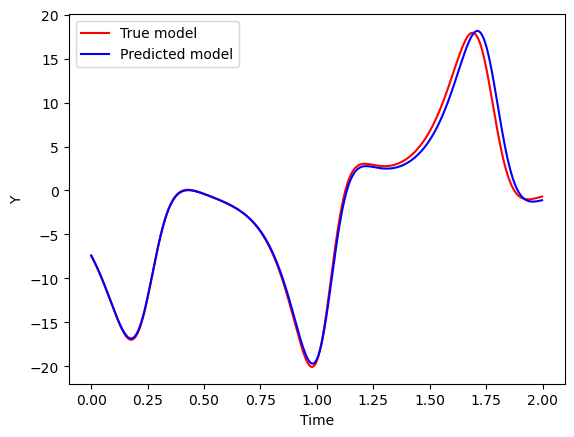

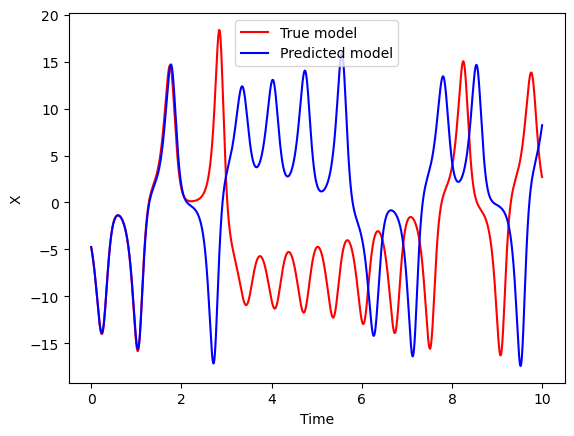

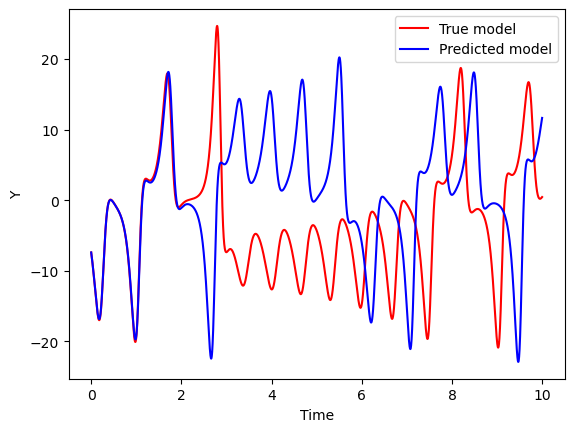

In [22]:
#### DETECTING DISTURBANCE USING SYSTEM RESERVOIR ####

### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
delsigma = 0
delrho = 10
delbeta = 0
err = np.zeros((m, ntest))
#fdist = np.zeros((m, ntest))

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)

gxnocontrol = np.zeros(ntest)
gynocontrol = np.zeros(ntest)
gznocontrol = np.zeros(ntest)

## For storing error time series data
#err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xxtrack, yytrack, zztrack = x, y, z


## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = (sigma + delsigma) * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * ((rho + delrho) - zznocontrol) - yynocontrol
    zznocontrolp = xxnocontrol * yynocontrol - (beta + delbeta) * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    gxnocontrol[t] = delsigma * (yynocontrol - xxnocontrol)
    gynocontrol[t] = delrho * xxnocontrol
    gznocontrol[t] = delbeta * zznocontrol

    #fdist[:, t] = np.array([xnocontrol[t], ynocontrol[t], znocontrol[t]])

    ## Predicted system
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + np.ones(n))
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

    err[0, t] = xxnocontrol - xxtrack
    err[1, t] = yynocontrol - yytrack
    err[2, t] = zznocontrol - zztrack


differr = np.zeros((m, ntest))
differr[:, 0] = err[:, 0]
differr[:, 1:] = np.diff(err, axis = 1) / dt

plottimerange = np.arange(0, 500)

plt.figure()
plt.plot(testingtimes[plottimerange], gxnocontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], err[0, plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gynocontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], err[1, plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gznocontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], err[2, plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z disturbance')
plt.show()





plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.5, label = 'Disturbance but no control')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')

plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')

plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()


# plt.figure()
# plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
# plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
# plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
# plt.legend()
# plt.show()




# plt.figure()
# plt.plot(testingtimes[100:200], ypure[100:200], 'r', label = 'True model')
# plt.plot(testingtimes[100:200], ynocontrol[100:200],  'g', label = 'Disturbed model')
# plt.legend()
# plt.show()

Seems super wrong. Gonna try with controlled trajectory and store that error.

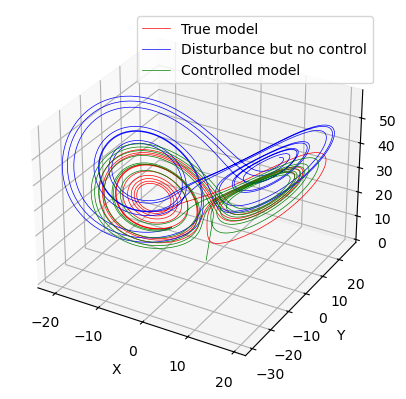

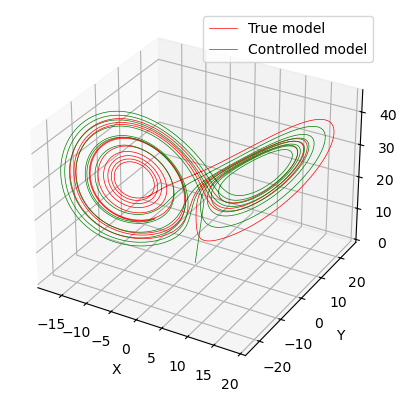

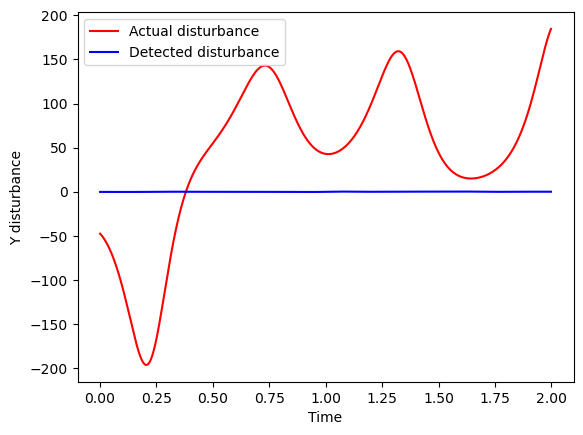

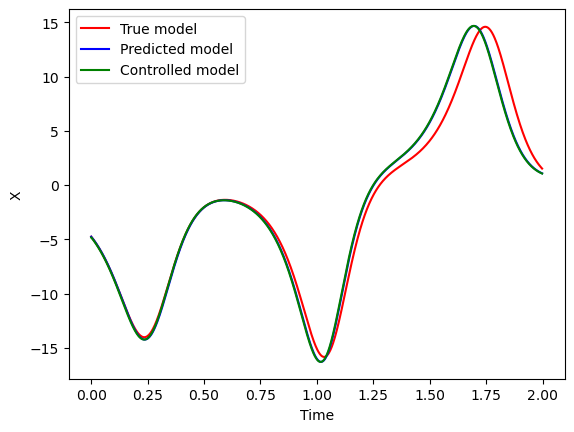

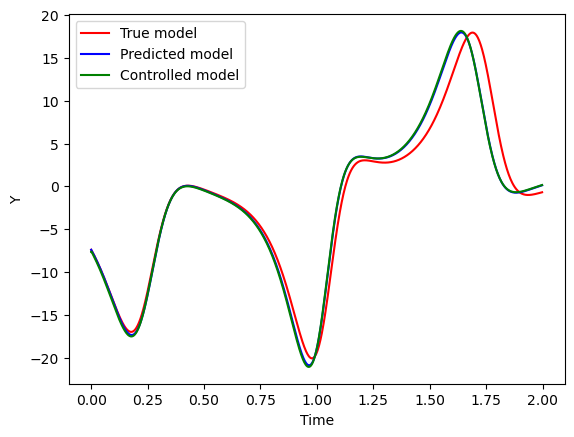

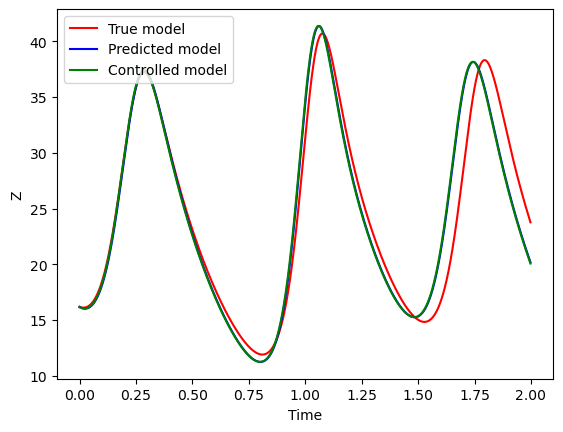

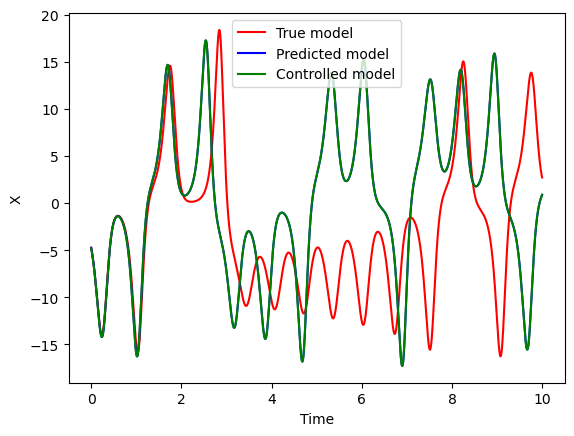

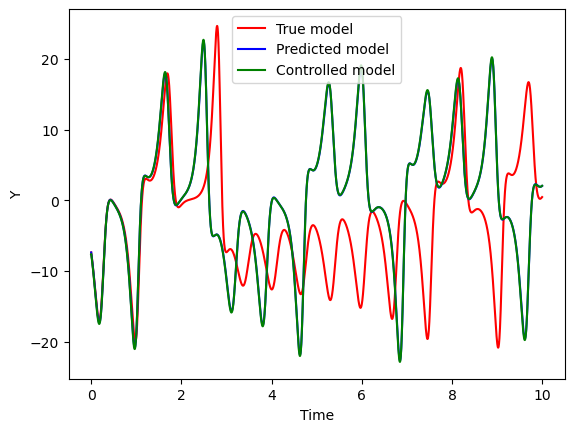

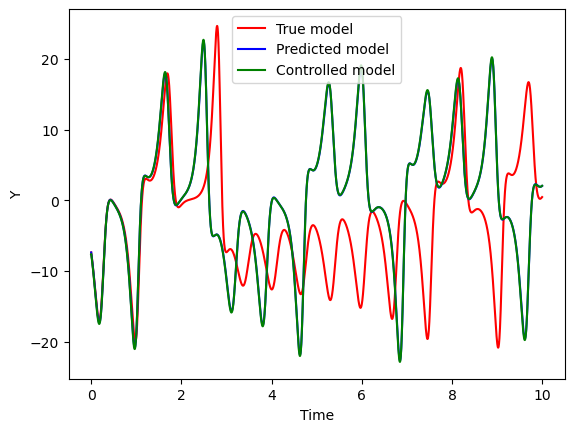

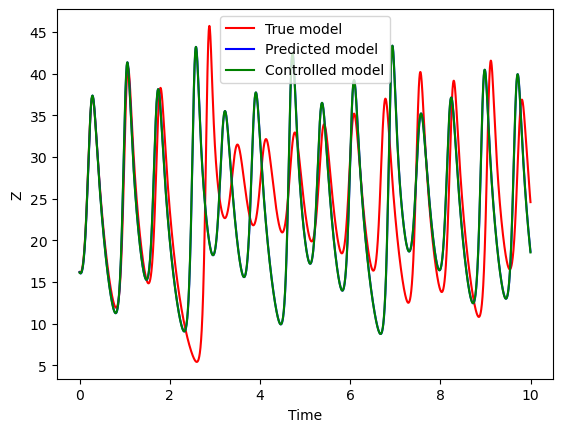

In [23]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
delsigma = 0
delrho = 10
delbeta = 0
controlgain = 1.5

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)


## For storing error time series data
gy = np.zeros(ntest)
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = (sigma + delsigma) * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * ((rho + delrho) - zznocontrol) - yynocontrol
    zznocontrolp = xxnocontrol * yynocontrol - (beta + delbeta) * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    gy[t] = delrho * xxnocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + np.ones(n))
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

    xxpidp = (sigma + delsigma) * (yypid - xxpid)
    yypidp = xxpid * ((rho + delrho) - zzpid) - yypid 
    zzpidp = xxpid * yypid - (beta + delbeta) * zzpid
    
    xxpid += dt * xxpidp + controlgain * (xxtrack - xxpid)
    yypid += dt * yypidp + controlgain * (yytrack - yypid)
    zzpid += dt * zzpidp + controlgain * (zztrack - zzpid)
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid

    err[t] = yytrack - yypid



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.5, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.5, label = 'Controlled model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.5, label = 'Controlled model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], gy[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], -err[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'b', label = 'Predicted model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'b', label = 'Predicted model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], zpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ztrack[plottimerange],  'b', label = 'Predicted model')
plt.plot(testingtimes[plottimerange], zpid[plottimerange],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], xpid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], ypid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], ypid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], zpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ztrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], zpid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z')
plt.show()






In [24]:
err

array([ 0.23804739,  0.12519217,  0.18302603, ..., -0.02177578,
       -0.02270794, -0.02363954])

Can also detect anomoly in signal maybe? Time-series anomoly detection. This website has useful evaluation stuff: https://timeeval.github.io/evaluation-paper/


Can create a more robust training phase by using multiple training forcing functions in the same reservoir. Add them all one by one, then combine the vectors to get a much bigger time-series record matrix R and f. Then find Wout matrix that minimizes the loss of the big reservoir. Individual detections would be worse but overall should be more robust for multiple different disturbance inputs.

Going to create a time-series, say a sine wave, with a slight anomaly. Then see if RC detects it.

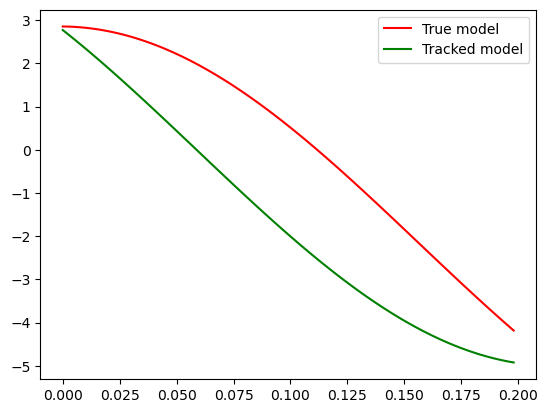

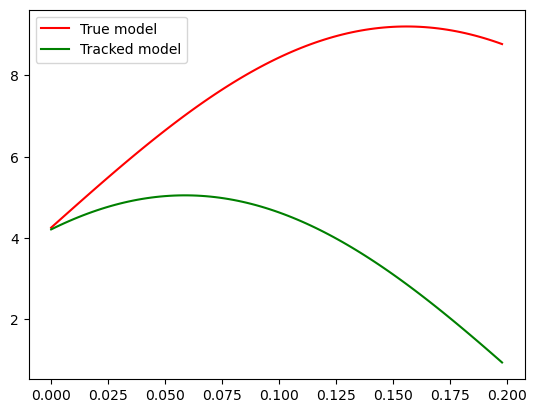

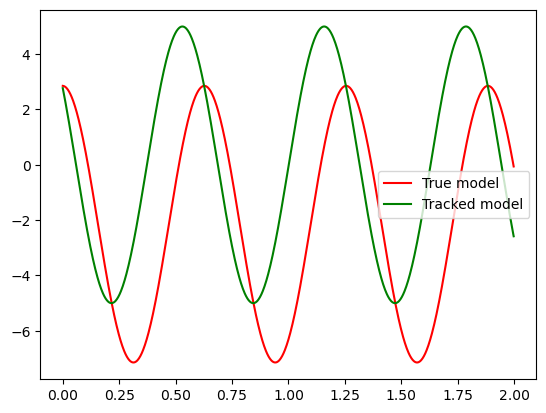

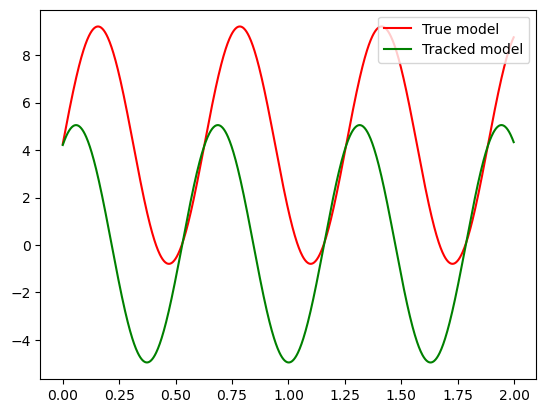

In [35]:
### Initializing parameters for training

## Reservoir parameters
n = 1000                    # reservoir size
m = 2                       # number of dimensions in the system  
mu = 0.001                     # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)
#A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f

radius = 5
freq = 10

x, y = radius, 0

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y])
    R[:, t] = rpid
    
    x = x - dt * radius * freq * np.sin(freq * dt * t)
    y = y + dt * radius * freq * np.cos(freq * dt * t)

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 20
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)


## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)


## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure = x, y
xxpid, yypid = x, y
xpid[0], ypid[0] = x, y
xtrack, ytrack = x, y

## Time evolution
for t in range(ntest):

    ## Ideal system
  

    xxpure = xxpure - dt * radius * freq * np.sin(freq * dt * t)
    yypure = yypure + dt * radius * freq * np.cos(freq * dt * t)

    xpure[t] = xxpure
    ypure[t] = yypure
   

    ## Actual system
    
    
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack])) + np.ones(n))
    xtrack, ytrack = Wout_pid.dot(rpid)
    
    

    xpid[t] = xtrack
    ypid[t] = ytrack




# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
# ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model')
# plt.legend()
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
# A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
# B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
# avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
# print('Average of minimum distances:', avgdist)

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

Interesting. So there's a phase shift. The model learns, say the downward going portion for the system, but the system is going up.

Without A

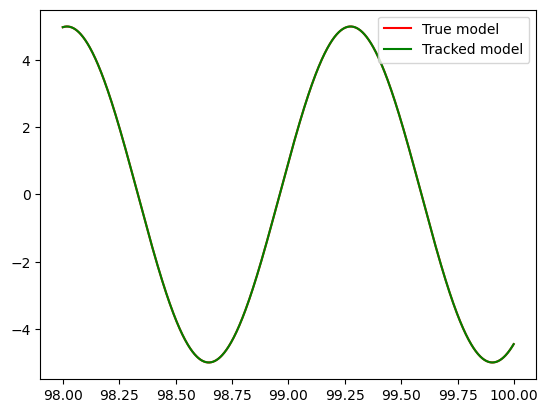

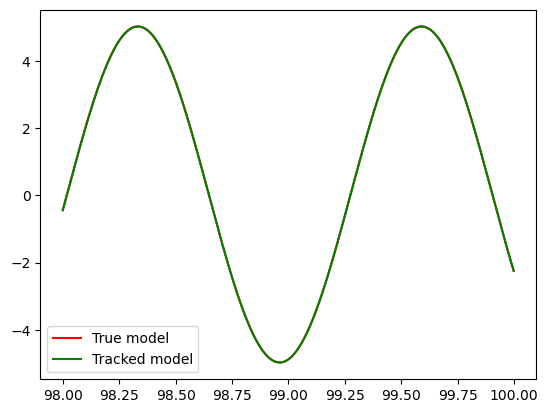

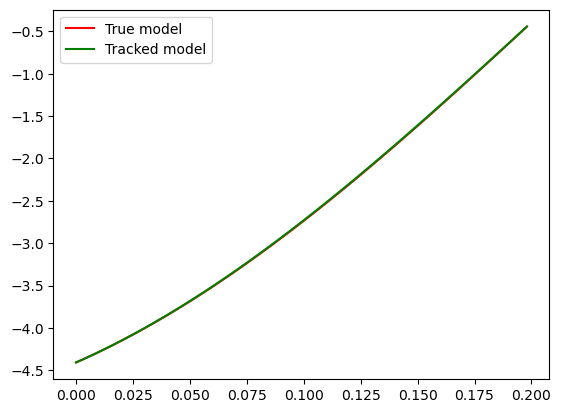

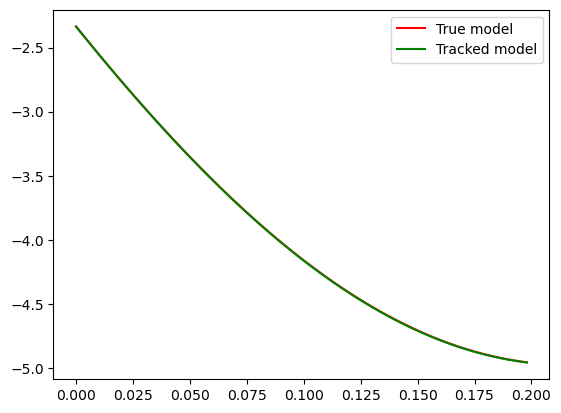

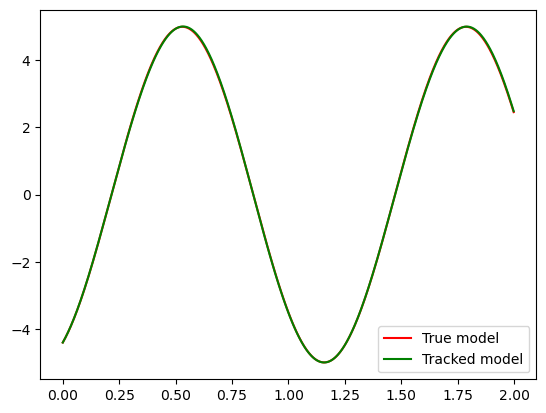

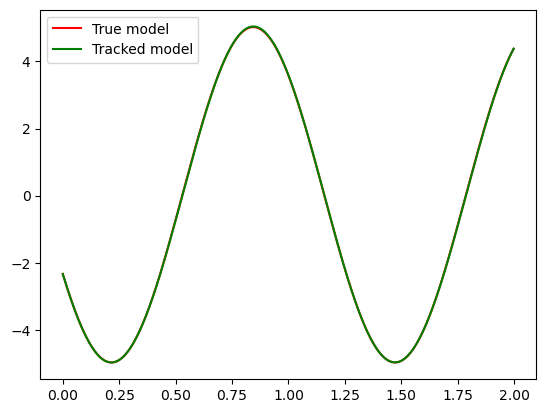

In [74]:
### Initializing parameters for training

## Reservoir parameters
n = 10                    # reservoir size
m = 2 + 1                       # number of dimensions in the system + 1 for bias term 
mu = 0.001                     # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
# A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
# A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
# A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
# A = sp.csr_matrix(A1)
#A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f

radius = 5
freq = 5

x, y = radius, 0

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, 1])
    R[:, t] = rpid
    
    x = x - dt * radius * freq * np.sin(freq * dt * t)
    y = y + dt * radius * freq * np.cos(freq * dt * t)

    rpid = np.tanh(Win.dot(u))
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Plotting training data

plottimerange = np.arange(ntraining - 1000, ntraining)

plt.figure()
plt.plot(trainingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
plt.plot(trainingtimes[plottimerange], Wout_pid.dot(R[:, plottimerange])[0],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(trainingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
plt.plot(trainingtimes[plottimerange], Wout_pid.dot(R[:, plottimerange])[1],  'g', label = 'Tracked model')
plt.legend()
plt.show()

### Testing

## Initializing testing parameters
Ttest = 20
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)


## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)


## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure = x, y
xxpid, yypid = x, y
xpid[0], ypid[0] = x, y
xtrack, ytrack = x, y

## Time evolution
for t in range(ntest):

    ## Ideal system
  

    xxpure = xxpure - dt * radius * freq * np.sin(freq * dt * (t + ntraining))
    yypure = yypure + dt * radius * freq * np.cos(freq * dt * (t + ntraining))

    xpure[t] = xxpure
    ypure[t] = yypure
   

    ## Actual system
    
    
    rpid = np.tanh(Win.dot(np.array([xtrack, ytrack, 1])))
    xtrack, ytrack = Wout_pid.dot(rpid)[0: m - 1]

    xpid[t] = xtrack
    ypid[t] = ytrack




# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
# ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model')
# plt.legend()
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
# A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
# B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
# avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
# print('Average of minimum distances:', avgdist)

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

Training data is fine. Why is the output phase and bias shifted?

Fixed it. Works great now. Should be able to do some time-series anomaly detection with this now.

Can a reservoir do fourier analysis? Maybe identify the constituent frequencies.

Do the disturbance with forcing function but using the actual x, y and z and difference values, not the force directly.

Train for multiple initial conditions by concatenating the f and R matrices to get a different Wout matrix that should be better - should neglect the initial condition and learns just the dynamics.

Make the system more noisy. See where the model breaks. Test robustness of model. Focus on time series anomaly detection. Do masking, hide some columns from the data randomly. Concatenate multiple time-series by concatenating the columns, see how to make the model more robust.

Use transformers to do forecasting

Test-time learning? Use reservoir to learn system. Then when system faces disturbance, identify the disturbance by subtracting from the prediction. Once the disturbance is identified, add the disturbance back to the model to make forecasting better. Maybe work on periodic data for this.

Get some theoretical bound for the deviation in forecast from the ideal trajectory. Show that the deviation is finite or low or something.

Use both control schemes to accurately identify the system - so instead of control, see if we can forecast the system accurately in the presence of the disturbances.

Detecting disturbance is something that could be used in diffusion neural nets.

Just try for any random signal, learn for a few seconds, then forecast it.